# Reducción de Dimensiones

A medida que aumenta la cantidad de dimensiones en el espacio de features, el volúmen de ese espacio auemnta también, por lo que los datos que tenemos en ese espacio (cantidad de muestras) tienden a representar una muestra pequeña y no representativa. Esto puede afectar la performance del clasificador/predictor incurriendo en lo que se conoce como *overfitting*. A esto se lo conoce como la maldición de la dimensionalidad (*curse of dimensionality*)

Por eso es importante contar con herramientas que nos permitan seleccionar el mejor subconjunto de features para el problema que buscamos resolver.

Existen dos enfoques:

-  Selección de variables: busco elegir el subconjunto de mis variables que mayor información aporten al problema que busco resolver. Ejemplo: criterio de información mutua, ANOVA, etc.


- Proyección de variables: busco transformar mis variables para llevarlas a un espacio de menor dimensión. Ejemplo: PCA, ICA, SVD, etc.

## Selección de características *(features)*

La selección de características intenta reducir el número de variables de entrada a aquellas que sean significativas para el modelo, es decir, que se evidencie un impacto sobre la variable de salida. 


Los distintos criterios de selección de features se pueden dividir en 3 categorías:
1. Métodos embebidos: la selección de features se encuentra naturalmente incorporada al proceso de modelado. Ej: árboles de decisión, LASSO
2. Métodos de filtrado: se realiza un análisis supervisado de los features para determinar cuales son los más relevantes, y sólo luego se procede al modelado. Ej. selección basada en test estadísticos.
3. Métodos Wrapper: emplean un método iterativo de búsqueda, donde en cada paso se da al predictor un subconjunto distinto de features, y utiliza la performance del predictor para guiar la selección del siguiente subconjunto de variables. Ej: eliminación recursiva de features (*recursive feature elimination* - RFE)

### Métodos básicos de selcción

Es recomendable eliminar aquellas variables que posean varianza nula (o muy pequeña). Asimismo puede ser beneficioso eliminiar variables que se encuentren altamente correlacionadas entre sí. 

**Veamos en un ejemplo:**

En casi todos los casos se quiere realizar este análisis sobre un subconjunto de datos de entranmiento, por lo tanto se particionarán los datos anteriores. Para ello, se puede utilizar la función train_test_split de Scikit-Learn

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets

In [2]:
X = np.column_stack((np.random.randn(1000,1), np.random.rand(1000,1)*2.5, np.random.randn(1000,1)*.01+3,
                    np.random.randn(1000,1)*.05+1, np.random.multivariate_normal([0,0], np.array([[1,0.95],[0.95,1]]),1000),
                     np.random.randn(1000,4), 0.43*np.ones((1000,1))))
y = X[:,0]**2 + 1.5*X[:,1] + 2*X[:,3] +.8*X[:,4] + X[:,-1]
df = pd.DataFrame(np.concatenate([X, y.reshape(-1,1)], axis=1),
             columns=['x{}'.format(i) for i in range(X.shape[1])]+['y'])

In [3]:
df.head(5)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,-1.773830,2.404152,2.992160,0.996146,-0.740655,-0.686715,-0.380875,-0.144984,0.128234,-0.063257,0.43,8.582470
1,0.303666,0.809985,2.991013,0.967913,0.087345,0.085602,-0.919912,0.373184,1.103305,1.500444,0.43,3.742893
2,-1.056709,2.168360,3.006147,1.076329,1.196998,1.120941,-1.734447,-1.239977,0.277442,-0.159753,0.43,7.909430
3,-1.747193,0.474334,3.017644,1.010414,0.639544,0.285132,0.552480,-0.222327,2.337414,-0.554217,0.43,6.726647
4,0.568224,0.059893,2.986896,1.031973,-0.959478,-1.256014,-1.827521,0.371831,-0.680161,1.403869,0.43,2.139083


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train.shape, X_test.shape

((670, 11), (330, 11))

### Eliminación de variables de varianza 0 (constantes)
**Implementación manual**: Busco aquellas variables con igual valor en todas las filas. Sirve para todo tipo de variables (numéricas o catecóricas)

In [5]:
n_unique = np.asarray([len(np.unique(x)) for x in X_train.T])
n_unique

array([670, 670, 670, 670, 670, 670, 670, 670, 670, 670,   1])

In [6]:
mask = n_unique > 1
X_train_red = X_train[:,mask]
X_test_red = X_test[:,mask]
X_train_red.shape, X_test_red.shape

((670, 10), (330, 10))

**Implementación usando Scikit-learn**. Sirve únicamente para variables numéricas.

In [7]:
from sklearn.feature_selection import VarianceThreshold
sel_0var = VarianceThreshold(threshold=0)
sel_0var.fit(X_train);
X_train_red = sel_0var.transform(X_train)
X_test_red = sel_0var.transform(X_test)
print(sel_0var.variances_)
X_train_red.shape, X_test_red.shape

[9.65941929e-01 5.39810005e-01 9.66628651e-05 2.60381009e-03
 9.88716388e-01 9.87442612e-01 8.67164081e-01 9.72414369e-01
 1.03139514e+00 1.03525107e+00 0.00000000e+00]


((670, 10), (330, 10))

### Eliminación de variables con baja varianza

**Implementación manual**: Estimo la varianza de cada variable y descarto aquellas con varianza por debajo de cierto umbral preestablecido

In [8]:
var = np.std(X_train, axis=0)**2
var

array([9.65941929e-01, 5.39810005e-01, 9.66628651e-05, 2.60381009e-03,
       9.88716388e-01, 9.87442612e-01, 8.67164081e-01, 9.72414369e-01,
       1.03139514e+00, 1.03525107e+00, 2.72280272e-29])

In [9]:
mask = var>0.01 # Armo una máscara con las variables con varianza mayor a 0.01
X_train_red = X_train[:,mask]
X_test_red = X_test[:, mask]
X_train_red.shape, X_test_red.shape

((670, 8), (330, 8))

**Implementación con Scikit-learn:**

In [10]:
sel = VarianceThreshold(threshold=0.01)
X_train_red = sel.fit_transform(X_train);
X_test_red = sel.transform(X_test)
print(sel.variances_)
X_train_red.shape, X_test_red.shape


[9.65941929e-01 5.39810005e-01 9.66628651e-05 2.60381009e-03
 9.88716388e-01 9.87442612e-01 8.67164081e-01 9.72414369e-01
 1.03139514e+00 1.03525107e+00 2.72280272e-29]


((670, 8), (330, 8))

### Eliminación de variables muy correlacionadas
En este caso vamos a utilizar el coeficiente de correlación de Pearson, que resulta de los más utilizados (luego veremos otras formas)

In [11]:
df_train = pd.DataFrame(X_train_red,columns=df.columns[:-1][sel.get_support()])
corr = df_train.corr()
corr.shape

(8, 8)

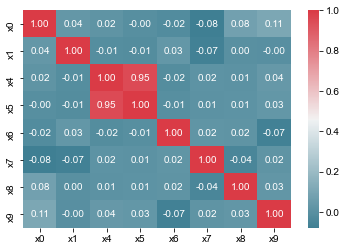

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(corr, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

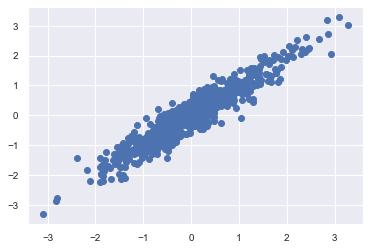

In [13]:
plt.scatter(df_train.x4, df_train.x5)

<font color='blue'>**Ejercicio**: Analizar distintas formas de seleccionar entre las variables x4 y x5. ¿Cuál sería conveniente retener? Analizar el efecto de las variables eliminadas utilizando algún algoritmo de regresión que conozcas </font>

### Métodos de filtrado

Una forma de seleccionar features es mediante tests de correlación entre la variable de entrada y de salida. El objetivo de estos tests es permitir identificar las variables que mayor impacto tienen sobre la salida y eliminar las restantes.

Según el tipo de variables que tengamos (continuas, numéricas o categóricas) usaremos distintos tests, como se resume en la siguiente tabla:

Caso | Variable de Entrada | Variable de Salida | Método                  
----|--------------------|--------------------|-----------------------
1 |Númerica            | Numérica           | Pearson, Spearman's, Información Mutua     
2 |Númerica            | Categórica         | ANOVA, Kendall's,Información Mutua                 
3 |Categórica          | Numérica | Poco frecuente.  
4 |Categórica          | Categórica | $\chi^2$, Información Mutua 

En general lo que se hace es efectuar el test correspondiente entre cada feature y la variable objetivo y quedarnos con los que tengan mayor impacto. Ya sea el $x$% de las variable o las $k$ mejores. También puede imponerse un umbral y retener todos los features con score por encima de ese valor. 

#### Repasemos un poco los distintos criterios
##### Estadísitcos de correlación:
Miden el grado de correlación entre cada feature y la variable de salida. Únicamente analiza la relación **lineal** entre ambas variables. En todos los casos, al estar analizando la correlación, vamos a obtener un estadísitco que toma valores entre -1 y 1. Aquellos más cercanos a -1 indican una relación lineal negativa fuerte (si una variable decrece, la otra crece), mientras que valores cercanos a 1 indican una fuerte realción lineal positiva. Los valores cercanos a 0 implican que no hay relación lineal entre las variables; esto podría ocurrir porque las variables son independientes o porque tengan una relación no lineal. ALERTA: mirando únicamente los coeficientes de correlación podemos estar descartando features informativos.

- Test correlación de Pearson:
    Se basa en el estadístico $r= \frac{\sum_{i=1}^n(X_i-\bar{X})(Y_i-\bar{Y})}{\sqrt{\sum_{i=1}^n(X_i-\bar{X})^2}\sqrt{\sum_{i=1}^n(Y_i-\bar{Y})^2}}$. Se observa que es el estimador para el coeficiente de correlación $\rho=\frac{cov(X,Y)}{\sigma_X\sigma_Y}$. Bajo la hipótesis de que $X$ e $Y$ se encuenran descorrelacionadas, $r\sim \chi^2_n$ **chequear grados de la chi2**
    - Asume distribución normal de las variables (se puede testear a traves del rest Shapiro-Wilk, un histograma o un QQ plot)
    - Asume relación lineal entre las variables (se puede evaluar haciendo un scatterplot de los datos)

- Test de correlación de Spearman:
    Es un test no paramétricos basado en rangos. Mide la relación monotónica entre dos variables X e Y. Se basa en el estadístico $\rho = 1 - \frac{6\sum d_i^2}{n(n^2-1)}$, donde $d_i$ es la diferencia entre las observaciones ordenadas de cada grupo $(x_{(i)}-y_{(i)})$.
    - Al ser un test no paramétrico, no hace suposiciones respecto de la distribución de los datos. 

- Test de correlación de Kendall: 
    - Test no paramétrico, i.e. no asume ninguna distribución de los datos
    - $H_0$: Las variables son independientes, $H_1$: Las variables no son independientes.
    - Se basa en el estadístico $\tau = {\frac {2}{n(n-1)}}\sum _{i<j}{sgn}(x_{i}-x_{j}){sgn}(y_{i}-y_{j})$ 
    - Orden $n^2$, si hay muchos datos puede ser muy costoso.
    
##### Estadísticos de independencia
La forma de analizar relaciones no lineales entre variables, es decir la independencia, es utilizando el crierio de información mutua. 
$$I(X,Y) = \int\int f_{X,Y}(x,y)\log\left(\frac{f_{X,Y}(x,y)}{f_X(x)f_Y(y)}\right)  dx\ dy = H(X) - H(X|Y)$$

#### Probemos algunos ejemplos:
##### Numérica  - Numérica 
Usemos los datos que ya generamos, con las variables que eliminamos.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
df_train = pd.DataFrame(np.concatenate([X_train_red,y_train[:,np.newaxis]], axis=1), 
                        columns=df.columns[np.concatenate([sel.get_support(), [True]])])
df_test = pd.DataFrame(np.concatenate([X_test_red,y_test[:,np.newaxis]], axis=1), 
                        columns=df.columns[np.concatenate([sel.get_support(), [True]])])
df_train.head(5) # El que cree antes


,x0,x1,x4,x5,x6,x7,x8,x9,y
0,0.036027,2.207010,-1.268919,-1.210636,0.149526,-0.012551,0.819684,0.815114,4.779170
1,-0.228304,1.367260,1.630733,1.362932,-0.131825,-0.660572,0.548272,-0.785597,5.867225
2,-0.343497,2.340965,-0.291818,-0.609417,0.096179,0.569189,-1.591949,0.501430,5.980040
3,-0.419711,0.015905,-0.799429,-0.966914,0.246651,-0.073319,0.896849,1.071283,1.942245
4,2.345525,1.684537,0.445425,0.180632,0.229782,-1.420315,0.940583,1.346790,10.765158


Chequeo condiciones para usar Pearson:

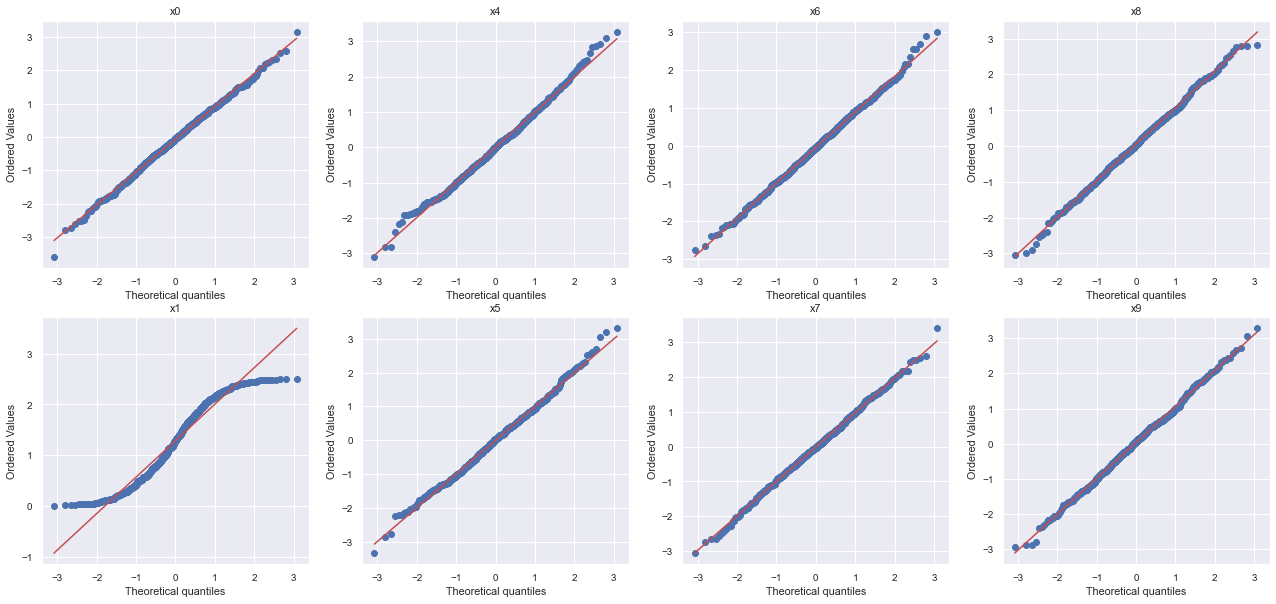

In [15]:
from scipy import stats
fig, axis = plt.subplots(2,4,figsize=(22,10)) 
for k, xi in enumerate(X_train_red.T):
    stats.probplot(xi, dist="norm", plot=axis[k%2,k//2])
    axis[k%2,k//2].set_title(df_train.columns.values[k])
    

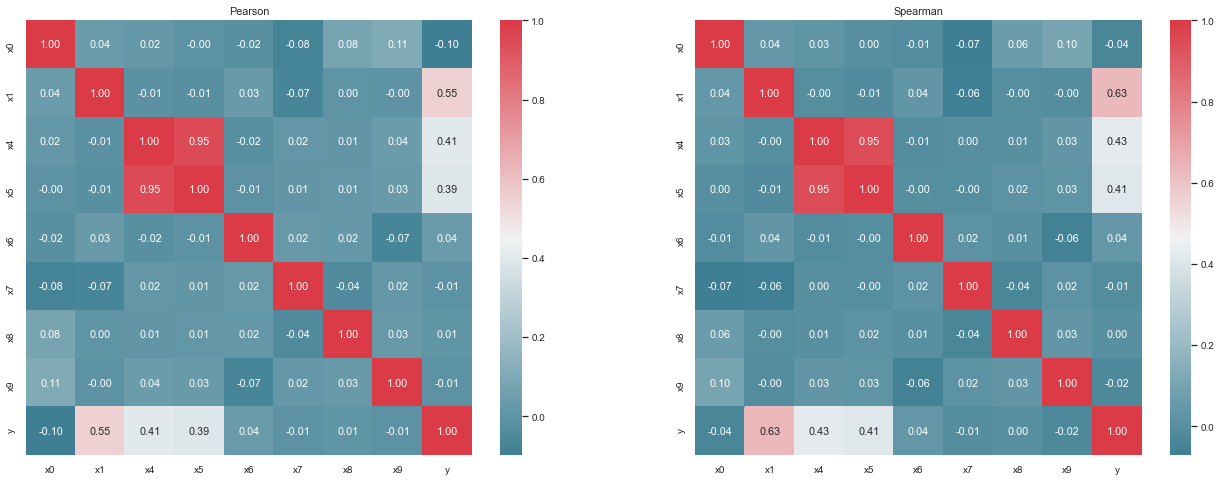

In [16]:
fig, axes = plt.subplots(1,2,figsize=(22,8))

r = df_train.corr(method='pearson')
axes[0].set_title("Pearson")
sns.heatmap(r, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f",ax=axes[0])
sns.set(font_scale=0.9)

rho = df_train.corr(method='spearman')
axes[1].set_title("Spearman")
sns.heatmap(rho, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)


Una vez obtenidos los coeficientes de correlación, puedo seleccionar los $k$ features con mayor correlción con la varible de salida. Asimismo, esta matriz nos permitiría eliminar variables cuya correlación sea muy alta. En este ejemplo se podría pensar en quedarse con $x_1$, $x_4$

- ¿Qué pasa si calculamos la MI?
Una nota sobre la los parámetros en la implementación: 
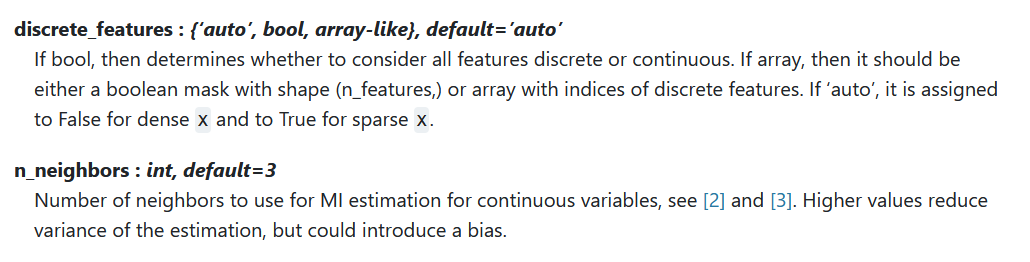

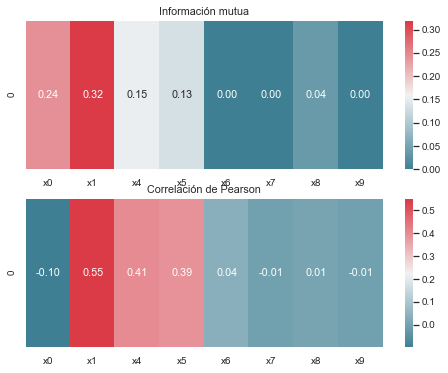

In [17]:
from sklearn.feature_selection import mutual_info_regression
MI = mutual_info_regression(X_train_red, y_train)
fig, ax = plt.subplots(2,1, figsize=(8,6))
ax[0].set_title('Información mutua')
sns.heatmap([MI],ax=ax[0],cmap=sns.diverging_palette(220,10,as_cmap=True), annot=True,fmt=".2f")
ax[0].set_xticklabels(df_train.columns.values[:-1])

ax[1].set_title('Correlación de Pearson')
sns.heatmap([r.iloc[-1][:-1]],cmap=sns.diverging_palette(220,10,as_cmap=True),ax=ax[1], annot=True,fmt=".2f")
ax[1].set_xticklabels(df_train.columns.values[:-1]);

¡Obervar que pasa con $x_0$!

La variable de salida $y = x_0^2 + 1.5x_1 + 2x_3 +.8x_4 + x_11$

##### Selección de features usando Scikit-Learn
 **NOTA**: el coeficiente de correlación de Pearson se utiliza en f_regression de Scikit-learn. 
 Calcula r, y define $F = \frac{r^2}{1 - r^2} (n-2) \sim F_{1,(n-2)}$


array([6.50924989e+00, 2.88491467e+02, 1.32823209e+02, 1.23156949e+02,
       9.60644732e-01, 2.57864351e-02, 1.99792868e-02, 3.23813308e-02])

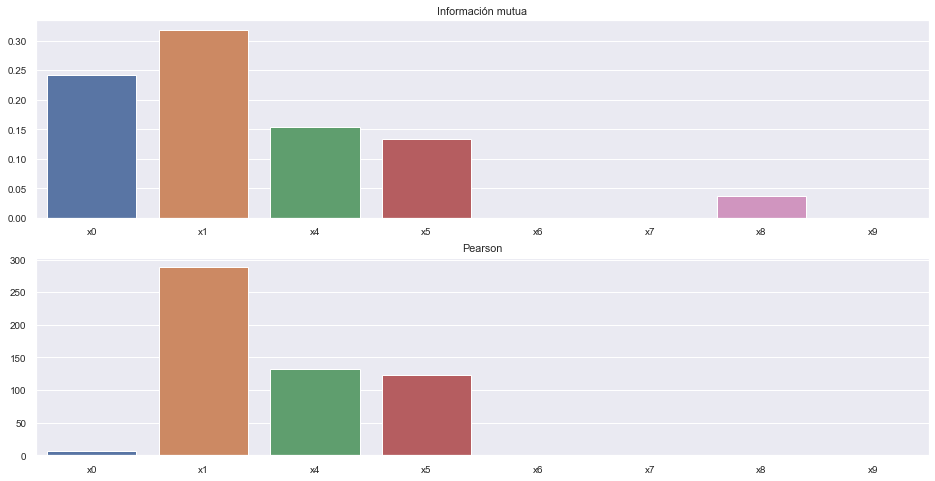

In [19]:
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.feature_selection import SelectKBest

def select_features_mutual_info(X_train, y_train, X_test,k= 'all'):  
  fs = SelectKBest(score_func=mutual_info_regression, k=k )  
  fs.fit(X_train, y_train)  
  X_train_fs = fs.transform(X_train)  
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs
def select_features_pearson(X_train, y_train, X_test,k= 'all'):  
  fs = SelectKBest(score_func=f_regression, k=k )  
  fs.fit(X_train, y_train)  
  X_train_fs = fs.transform(X_train)  
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

X_train_mi, X_test_mi, mi = select_features_mutual_info(X_train_red, y_train, X_test_red)
X_train_pc, X_test_pc, pc = select_features_pearson(X_train_red, y_train, X_test_red)
fig,axes = plt.subplots(2,1,figsize=(16,8))
axes[0].set_title('Información mutua')
sns.barplot( x = [c for c in df_train.columns[:-1] ], y = mi.scores_,ax=axes[0])
axes[1].set_title('Pearson')
sns.barplot( x = [c for c in df_train.columns[:-1] ], y = pc.scores_,ax=axes[1]); #Grafico el F score de cada feature
pc.scores_

##### Numérica - Categórica
Usamos el set de datos [winequality-red](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009), donde se midieron distintos aspectos de distintos vinos, y se los clasifica según su calidad en una escala del 1 al 10. 

In [20]:
df = pd.read_csv('winequality-red.csv')
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


**Coeficiente de Kendall** 

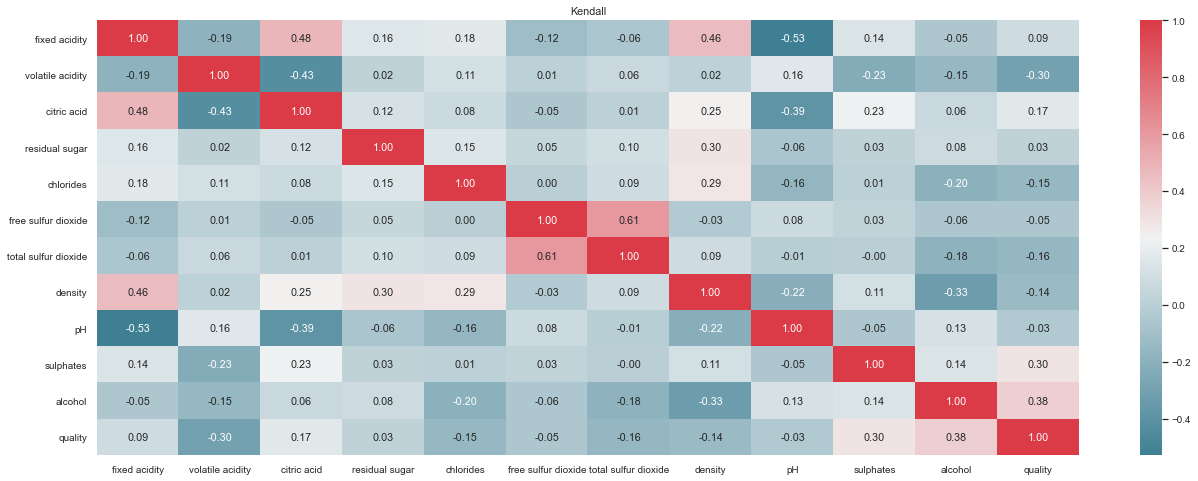

In [21]:
fig, axes = plt.subplots(1,1,figsize=(22,8))

tau = df.corr(method='kendall')
axes.set_title("Kendall")
sns.heatmap(tau, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)


**Selección de features usando ANOVA y MI en Scikit-learn**

El test F de ANOVA está implementado en la función <tt> f_classif </tt>. Observar también  que cuando la variable de salida es categórica debemos usar la  <tt> función mutual_info_classif </tt>

In [22]:
X, y = df[df.columns[:-1]],df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (1071, 11) (1071,)
Test: (528, 11) (528,)


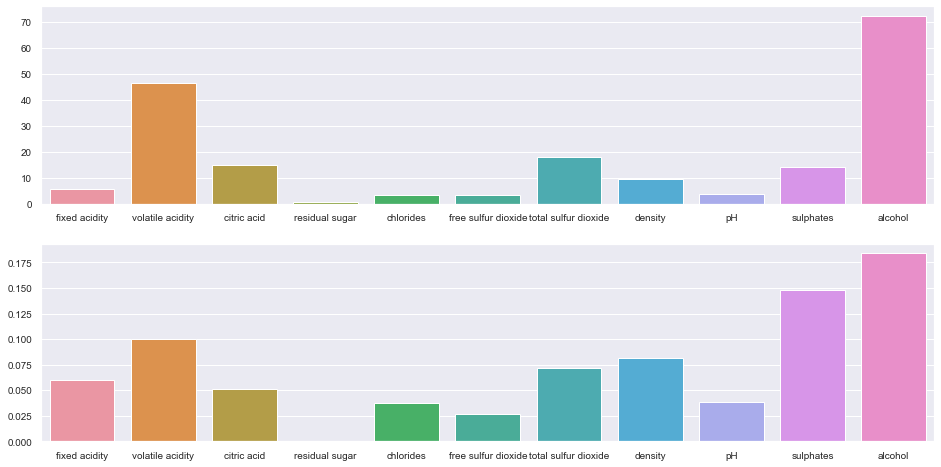

In [23]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest

def select_features_anova(X_train, y_train, X_test,k= 'all'):  
  fs = SelectKBest(score_func=f_classif, k=k )  
  fs.fit(X_train, y_train)  
  X_train_fs = fs.transform(X_train)  
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs
def select_features_mi(X_train, y_train, X_test,k= 'all'):  
  fs = SelectKBest(score_func=mutual_info_classif, k=k )  
  fs.fit(X_train, y_train)  
  X_train_fs = fs.transform(X_train)  
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

X_train_anova, X_test_anova, anova = select_features_anova(X_train, y_train, X_test)
fig,axes = plt.subplots(2,1,figsize=(16,8))
sns.barplot( x =df.columns[:-1].values, y = anova.scores_,ax=axes[0])

X_train_mi, X_test_mi, mi = select_features_mi(X_train, y_train, X_test)
sns.barplot( x =df.columns[:-1].values, y = mi.scores_,ax=axes[1]);


¿Qué se puede concluir?

#### Categórica - Categórica
Vamos a usar como ejemplo el [dataset](https://www.kaggle.com/uciml/mushroom-classification) de hongos venenosos y comestibles.  Interesa identificar cuales son las características (forma de sombrero, olor, etc.) que determinan si es o no comestible.

In [24]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [25]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


#### Preparación del dataset

Como se pudo ver en el paso anterior, el dataset contiene las categorías en forma de texto, por lo tanto es necesario codificarlas. Se utilizará One Hot Encoding con Pandas.

In [26]:
df[:].astype('category')
df.dtypes

class                       object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

In [27]:
df = pd.get_dummies(df)
df.dtypes

class_e        uint8
class_p        uint8
cap-shape_b    uint8
cap-shape_c    uint8
cap-shape_f    uint8
               ...  
habitat_l      uint8
habitat_m      uint8
habitat_p      uint8
habitat_u      uint8
habitat_w      uint8
Length: 119, dtype: object

In [28]:
df.loc[df.class_e==1,'p'] = 1
df.loc[df.class_p==1,'p'] = 0
df = df.drop(columns=['class_e','class_p'])

In [29]:
X, y = df[df.columns[:-1]],df[df.columns[-1]]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (5443, 117) (5443,)
Test: (2681, 117) (2681,)


#### $\chi^2$ (con selector de Features de SKLearn)

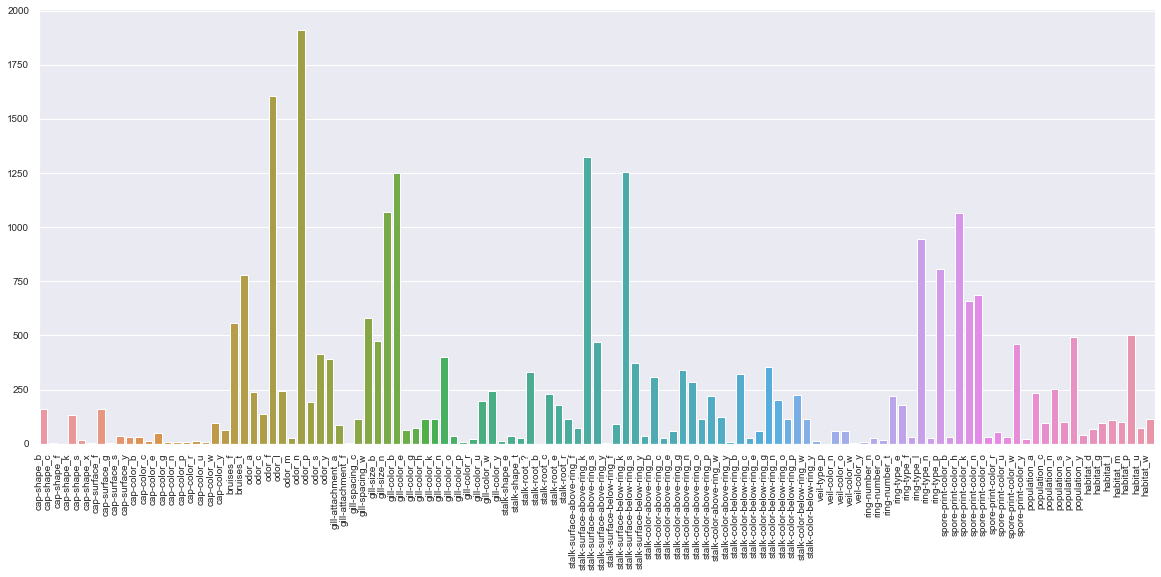

In [31]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

def select_features_chi2(X_train, y_train, X_test,k= 'all'):  
  fs = SelectKBest(score_func=chi2, k=k )  
  fs.fit(X_train, y_train)  
  X_train_fs = fs.transform(X_train)  
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features_chi2(X_train, y_train, X_test)
fig,axes = plt.subplots(1,1,figsize=(20,8))
bar = sns.barplot( x = [c for c in df.columns[:-1] ], y = fs.scores_,ax=axes)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

#### Información Mutua (con selector de Features de SKLearn)

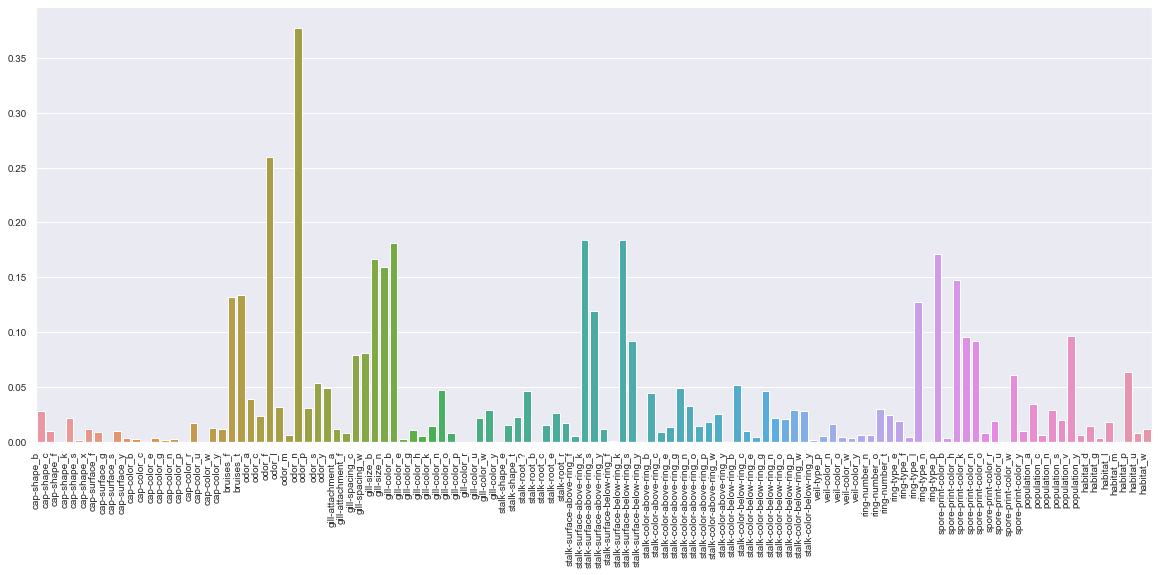

In [32]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

def select_features_mutual_info(X_train, y_train, X_test,k= 'all'):  
  fs = SelectKBest(score_func=mutual_info_classif, k=k )  
  fs.fit(X_train, y_train)  
  X_train_fs = fs.transform(X_train)  
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features_mutual_info(X_train, y_train, X_test)
fig,axes = plt.subplots(1,1,figsize=(20,8))
bar = sns.barplot( x = [c for c in df.columns[:-1] ], y = fs.scores_,ax=axes)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

<font color='blue'>Ejercicio: Probar los distintos criteros de selección de features utilizando algún algoritmo de aprendizaje automático apropiado y sacar conslusiones </color>

#### Algunas observaciones
- Ventajas:
    - Son simples y suelen ser rápidos de computar,
- Desventajas:
    - Propensos a la sobre selección de variables,
    - Puede haber desconección entre lo que el test reconoce como importante y lo que necesita el modelo.

## Bibliografia:
[1] "Python Machine Learning Cookbook, practical solutions from preprocessing to deep learning", Albon, Cris. O'Reilly Media, Inc., 2018.

[2] "Feature Engineering and Selection, A Practical Approach for Predictive Models", Max Khun and Kjell Johnson. CRC Press, 2020. 

[3] https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression3.html

[4] ["Measures of Association How to Choose?" Harry Khamis, PhD. Jpurnal of Diagnostic Medical Sonography May/June 2008 VOL. 24, NO. 3](https://journals.sagepub.com/doi/pdf/10.1177/8756479308317006)

[5] ["The Kendall Rank CorrelationCoefficient", Hervé Abdi](https://personal.utdallas.edu/~herve/Abdi-KendallCorrelation2007-pretty.pdf)
